#  Probabilistic Matrix Factorization of the MovieLens Ratings

Something something . Matrix factorization is a simple and powerful technique for predicting user's ratings of items using embedding in a latent space.

Modern methods have many useful adaptations, but the general system predicts user $u$'s rating of item $i$, $r_{u,i}$  as 
  *  $r_{u,i} = \mu + \beta_u + \beta_i + \vec{v}_u^T \cdot \vec{v}_i^T$
  *  $\mu$, $\beta_u$, and $\beta_i$ are overall mean ratings and offsets for users and movies
  *  $\vec{v}_i, \vec{v}_u \in \mathbb{R}^K$ are the user's and movie's embeddings in a $K$ dimensional space.
  *  We regularize user and item vectors by modeling them as coming from a multivariate gaussian, which can be learned or predetermined $\vec{v}_u \sim N(0, \Lambda_{\text{Users}})$ and $\vec{v}_i \sim N(0, \Lambda_{\text{Movies}})$.

The most famous application of PMF for recomendation systems is probably Netflix's.  Their system is described in [this paper](https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf) and you can also find a readable overview [here](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf).  Netflix took down the original dataset due to privacy concerns, but you can still run the same model using the [MovieLens data](https://grouplens.org/datasets/movielens/20m/).

Need to cite `MovieLens` with ```F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872```.

The MovieLens data comes contains 20,000,263 ratings of 27,278 movies by 138,493 users. It also contains free text tags, but we will not use them here. 

##  Read in the Data

Download [the data](https://grouplens.org/datasets/movielens/) and unzip.

We will only use `ml-20/movies.csv` and `ml-20/ratings.csv`.

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

%pylab inline

movies = pd.read_csv('~/ml-20m/movies.csv')
ratings = pd.read_csv('~/ml-20m/ratings.csv')

Populating the interactive namespace from numpy and matplotlib


In [15]:
print(movies.shape)
movies.head()

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
print(ratings.shape)
ratings.head()

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Let's cherry pick a few movies whose parameters we will track.  We'll pick the ones with the most ratings - hopefully our latent dimensions will be interpretable. 

We'll also bring in the titles now.  We'll need to remap the user and movie IDs, and bringing in the titles helps make sure we don't make mistakes mapping them back later on.

In [17]:
ratings = ratings.merge(movies, on = 'movieId', how = 'left')

In [18]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [19]:
ratings['title'].value_counts()[0:5]

Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: title, dtype: int64

In [20]:
ratings.loc[ratings['rating'] >= 4.0]['title'].value_counts()[0:5]

Shawshank Redemption, The (1994)             55807
Pulp Fiction (1994)                          52353
Silence of the Lambs, The (1991)             50114
Forrest Gump (1994)                          47331
Star Wars: Episode IV - A New Hope (1977)    42612
Name: title, dtype: int64

In [21]:
ratings.loc[ratings['rating'] <= 1.0]['title'].value_counts()[0:5]

Dumb & Dumber (Dumb and Dumber) (1994)    4578
Ace Ventura: Pet Detective (1994)         4323
Ace Ventura: When Nature Calls (1995)     3976
Waterworld (1995)                         3013
Blair Witch Project, The (1999)           2992
Name: title, dtype: int64

##  More Munging and EDA

We have 20 million ratings here, so let's take a look at their distribution across users and movies before running anything.  We will also create category codes for users and movies that start at zero and run through $N_{\text{Movies}}$ and $N_{\text{Users}}$, since we will need to use them for indexing with `tf.gather`. 

In [26]:
N_ratings = ratings.shape[0]
N_movies = len(set(ratings['movieId']))
N_users = len(set(ratings['userId']))

In [27]:
print('There are {} ratings of {} movies by {} users.'.format(
    N_ratings, N_movies, N_users))

There are 20000263 ratings of 26744 movies by 138493 users.


In [38]:
movie_counts = ratings.groupby('movieId').size()

In [60]:
np.median(movie_counts)

18.0

In [62]:
np.mean(movie_counts < 5)

0.31405174992521689

We may want to consider dropping mo

In [63]:
user_counts = ratings.groupby('userId').size()

In [64]:
np.median(user_counts)

68.0

In [79]:
np.min(user_counts)

20

In [74]:
user_counts.quantile([0.25, 0.50, 0.75])

0.25     35.0
0.50     68.0
0.75    155.0
dtype: float64

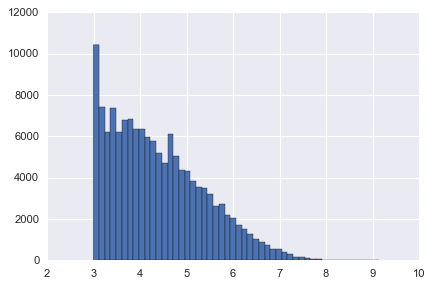

In [70]:
_, _, _ = plt.hist(np.log(user_counts.values), 50)

It looks like we've grabbed the top users' ratings.  There are no users with fewer than 20 ratings. 

##  Creating Categories

In [107]:
ratings['user_codes'] = ratings['userId'].astype('category').cat.codes
ratings['movie_codes'] = ratings['movieId'].astype('category').cat.codes
ratings['rating'] = ratings['rating'].astype(float)

In [82]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres,user_codes,movie_codes
0,1,2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy,0,1
1,1,29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,28
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,31
3,1,47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,46
4,1,50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,49


In [98]:
movie_categories = ratings['movieId'].astype('category').cat.categories

Now after we fit a model using `movie_codes`, we can go back and get the corresponding `movieId` with the `.cat.categories` object.

In [101]:
movie_categories[[1,28,31,46,49]]

Int64Index([2, 29, 32, 47, 50], dtype='int64')

In [117]:
movie_ids_df = pd.DataFrame({
    'movieId': movie_categories,
    'movie_codes': range(N_movies)
})

We can also use this dataframe as a way to merge back in learned parameters into the movies dataframe. 

##  Model Definition

Let's go ahead and define our model before we reformat our data.

We will use a vanilla PMF - exactly the one defined above, with predetermined $\Lambda_{\text{movies}} = \Lambda_{\text{users}} = I_K$ and $K=3$.

In [122]:
from edward.models import Normal
#  This will need to change if you train/test split
N_users = len(set(ratings.userId))
N_movies = len(set(ratings.movieId))
N_ratings = ratings.shape[0]
K = 2

#  Allow offsets to have differen regularization from latent vecs
#  Offsets
lnvar_user_betas = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
lnvar_movie_betas = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

sigma_user_betas = tf.sqrt(tf.exp(lnvar_user_betas))
sigma_movie_betas = tf.sqrt(tf.exp(lnvar_movie_betas))

#  Latent vecs
lnvar_user_vecs = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
lnvar_movie_vecs = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))

sigma_user_vecs = tf.sqrt(tf.exp(lnvar_user_vecs))
sigma_movie_vecs = tf.sqrt(tf.exp(lnvar_movie_vecs))


user_vecs = Normal(loc = tf.zeros([N_users, K]), 
                   scale = sigma_user_vecs * tf.ones([N_users, K]))
movie_vecs = Normal(loc = tf.zeros([N_movies, K]), 
                    scale = sigma_movie_vecs * tf.ones([N_movies, K]))

#  Somewhat hacky prior on mu
mu = Normal(loc = 2.5*tf.ones([1]), 
            scale = tf.ones([1]))

user_betas = Normal(loc = tf.zeros([N_users]), 
                    scale = sigma_user_betas * tf.ones([N_users]))
movie_betas = Normal(loc = tf.zeros([N_movies]), 
                     scale = sigma_movie_betas * tf.ones([N_movies]))

#  Placeholders for data inputs
user_ids = tf.placeholder(tf.int32, [N_ratings])
movie_ids = tf.placeholder(tf.int32, [N_ratings])

predicted_ratings = tf.reduce_sum(tf.multiply(
    tf.gather(user_vecs, user_ids),
    tf.gather(movie_vecs, movie_ids)
)) + \
    tf.gather(user_betas, user_ids) + \
    tf.gather(movie_betas, movie_ids) + \
    mu

obs_ratings = Normal(loc=predicted_ratings, scale = tf.ones([N_ratings]))

##  Inference Definition

We have now sret up a probablistic graph for generating ratings from our learnable paramters (mu, offsets, and vectors).  We now explicitly define our inference.  Edward makes it easy to swap out sampling, ML, and variational methods.  We'll use simple MFVI.  

In [123]:
# INFERENCE
q_user_vecs = Normal(loc=tf.Variable(tf.random_normal([N_users, K])),
                     scale=tf.nn.softplus(tf.Variable(tf.random_normal([N_users, K]))))
q_movie_vecs = Normal(loc=tf.Variable(tf.random_normal([N_movies, K])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([N_movies, K]))))

q_user_betas = Normal(loc=tf.Variable(tf.random_normal([N_users])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([N_users]))))
q_movie_betas = Normal(loc=tf.Variable(tf.random_normal([N_movies])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([N_movies]))))

q_mu = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
q_lnvar_users = Normal(loc=tf.Variable(tf.random_normal([1])),
                       scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
q_lnvar_movies = Normal(loc=tf.Variable(tf.random_normal([1])),
                        scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

                                    
parameter_inferences = {
    user_vecs: q_user_vecs,
    movie_vecs: q_movie_vecs,
    user_betas: q_user_betas,
    movie_betas: q_movie_betas,
    mu: q_mu,
    lnvar_users: q_lnvar_users,
    lnvar_movies: q_lnvar_movies
}
train_data = {
    user_ids: ratings['user_codes'].values,
    movie_ids: ratings['movie_codes'].values,
    obs_ratings: ratings['rating'].values
}

inference = ed.KLqp(parameter_inferences,
                    train_data)

#  Run the Inference

We now have everything set up and can let SGD run. 

In [132]:
#optimizer = tf.train.FtrlOptimizer(learning_rate=1e-2)
optimizer = tf.train.AdamOptimizer(1e-4)
n_iter = 400
n_print = 20

inference.initialize(optimizer = optimizer,
                     n_print=n_print, n_iter=n_iter)
tf.global_variables_initializer().run()

In [133]:
loss = np.empty(n_iter, dtype=np.float32)

In [134]:
for i in range(inference.n_iter):
    info_dict = inference.update()
    
    loss[i] = info_dict['loss']
    inference.print_progress(info_dict)
    #inference.print_progress(info_dict)
    #if info_dict['t'] % inference.n_print == 0:
    #    l_per_rating = info_dict['loss'] / (1.0 * N_ratings)
    #    print('Iter: {}    Loss per rating: {} \n'.format(info_dict['t'], l_per_rating))
    

400/400 [100%] ██████████████████████████████ Elapsed: 446s | Loss: 131310144192512.000


This plot taken directly from [Dada Romeo's excellent HPF post](https://github.com/dadaromeo/recsys-hpf).

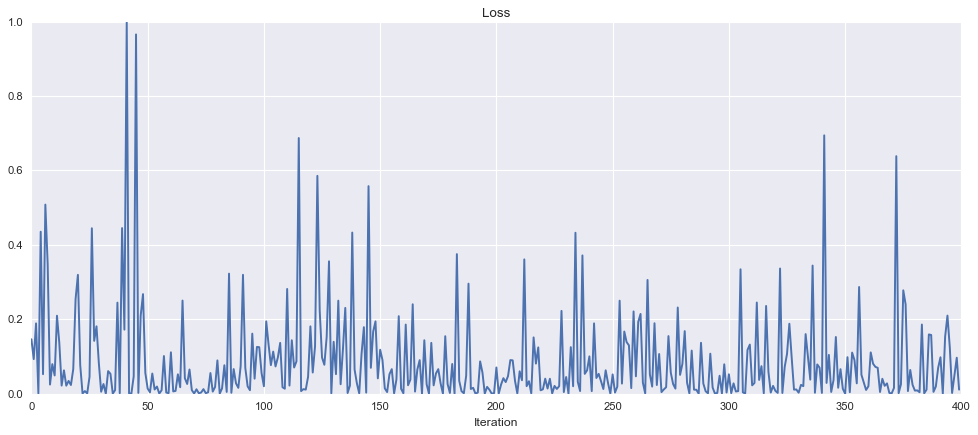

In [136]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.plot(loss / loss.max())
ax.set_title("Loss")
ax.set_xlabel("Iteration")

It looks pretty clear to me that this isn't close to converging to anything. 

#  Model Criticism

Just as a first sanity check, let's see which movies the model thinks are best. 

In [140]:
fit_movie_means = q_movie_betas.mean().eval()

movie_ids_df['fit_beta'] = fit_movie_means
movie_betas_df = movie_ids_df.merge(movies, on = 'movieId', how='left')
movie_betas_df.sort_values(['fit_beta']).head()

,movieId,movie_codes,fit_beta,title,genres
2305,2390,2305,-4.132682,Little Voice (1998),Comedy
17056,86508,17056,-3.958441,Japanese Summer: Double Suicide (Muri shinjû: ...,Crime|Drama
25598,124943,25598,-3.611611,Murder on a Honeymoon (1935),Comedy|Mystery
3320,3408,3320,-3.593569,Erin Brockovich (2000),Drama
9969,32770,9969,-3.520011,Brothers (Brødre) (2004),Drama


In [145]:
movie_betas_df.sort_values(['fit_beta'], ascending=False).head(5)

,movieId,movie_codes,fit_beta,title,genres
18547,92520,18547,3.700416,"Chocolate Soldier, The (1941)",Comedy|Musical
9452,27740,9452,3.673890,Blind Shaft (Mang jing) (2003),Drama
12557,58889,12557,3.578357,"Business of Being Born, The (2008)",Documentary
17977,90353,17977,3.574041,Beautiful Boy (2010),Drama
5320,5417,5320,3.528798,"Fast Runner, The (Atanarjuat) (2001)",Drama|Fantasy


It pretty clearly looks to me like the model is not yet finding ratings make much sense.  It's also pretty clear the infernce is not converging.  I'm going to allow betas and latent vecs to have different regularizations and will rerun.  

Let's also check the other learned parameters to see if they make sense.

In [142]:
print('Mu is at {}'.format(q_mu.mean().eval()))

print('Sigma for movies is at {}'.format(np.sqrt(np.exp(q_lnvar_users.mean().eval()))))
print('Sigma for users is at {}'.format(np.sqrt(np.exp(q_lnvar_movies.mean().eval()))))

Mu is at [ 0.13103066]
Sigma for movies is at [ 1.26930201]
Sigma for users is at [ 0.69336605]


We can also check out the distribution of fit offsets for movies. Nothing too concerning.

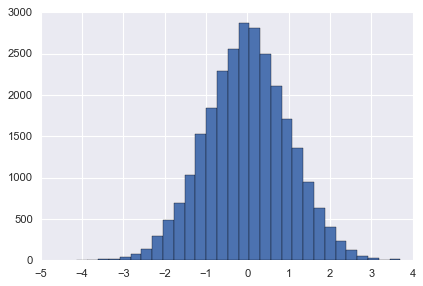

In [143]:
_, _, _ = plt.hist(fit_movie_means, 30)

#  Visualizing the Latent Dimensions

Now let's see if the factorization has learned meaningfull embeddings.

First let's pick a small subset of the movies to plot.

In [ ]:
movie_counts = ratings['movieId'].value_counts()